In [1]:
import sys
sys.path.append('/Library/Python/2.7/site-packages')
from scipy.sparse import diags
from scipy.linalg import block_diag
from scipy.sparse import dia_matrix, bmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def a(number):
    diag = map(np.sqrt,range(1, number))
    return diags([diag], [1], shape=(number, number)).toarray()


def basis(number, state):
    ket = np.zeros(number)
    ket[state] = 1
    ket.reshape(number, 1)
    return ket
    
def average(operater_list):
    return reduce(lambda x, y: np.dot(x, y), operater_list)

def sigmaz():
    x=[]
    for i in range(2):
        if i < 1:
            x.append(-1)
        else:
            x.append(1)
    return diags([x], [0], shape=(2, 2)).toarray()

def sigmax():
    x = [1]
    return diags([x,x], [1,-1], shape=(2, 2)).toarray()

In [3]:
def H_qubit(Ec, Ej, N_cutoff, ng, flux, d):
    # nondiag elements #
    nondiag = -0.5*Ej*np.cos(np.pi*flux)*np.sqrt(1 + (d *np.tan(np.pi*flux))**2)
    
    # diag elements #
    diag = []
    for n_charge in range(-N_cutoff, N_cutoff + 1, 1):
        diag.append(4*Ec*(n_charge - ng)**2)

    # return a sparse matrix #
    return diags([nondiag, diag, nondiag], [-1, 0, 1], shape=(2*N_cutoff+1, 2*N_cutoff+1)).toarray()

def H_lc(w_lc, N_phonon):
    return w_lc * np.dot(a(N_phonon).transpose(), a(N_phonon))

In [4]:
# qubit - lc hamiltionian in dressed state #
def H_qlc(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon):
    # diagnal elements #
    diag = []
    for j in range(N_phonon):
        for i in range(2*N_cutoff + 1):
            diag.append(H_qubit(Ec, Ej, N_cutoff, ng, flux, d)[i,i] + H_lc(w_lc, N_phonon)[j,j])
    # nondiagnal elements #
    nondiag = H_qubit(Ec, Ej, N_cutoff, ng, flux, d)[1,2] 
    return diags([nondiag, diag, nondiag], [-1, 0, 1], shape=((2*N_cutoff+1)*N_phonon, (2*N_cutoff+1)*N_phonon)).toarray()
     
def H_int(N_cutoff, g_lc, ng, N_phonon):
    int = []
    sum_int = []
    for n_charge in range(-N_cutoff, N_cutoff + 1, 1):
        int.append(g_lc*(n_charge-ng))
    for i in range(N_phonon-1):
       sum_int.extend(int)
    return diags([sum_int, sum_int], [-(2*N_cutoff+1), 2*N_cutoff+1], shape=((2*N_cutoff+1)*N_phonon, (2*N_cutoff+1)*N_phonon)).toarray()

# dressed state total hamiltionian #
def Hamltionian(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon, g_lc):
    return H_qlc(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon) + H_int(N_cutoff, g_lc, ng, N_phonon)

In [5]:
# diagnal qubit hamiltionian #
def diag_Hq(N_qubit,Ec, Ej, N_cutoff, ng, flux, d):
    Q_energy = []
    Qubit = []
    evals, evects = np.linalg.eigh(H_qubit(Ec, Ej, N_cutoff, ng, flux, d))
    for i in range(N_qubit):
        Q_energy.append(evals[i])
    Qubit.append(Q_energy)
    Qubit.append(evects.transpose())
    U_transform = average([np.linalg.inv(evects),H_qubit(Ec, Ej, N_cutoff, ng, flux, d),evects])[:N_qubit,:N_qubit]
    Qubit.append(U_transform)
    return Qubit

e, s, m = diag_Hq(2, 1, 10, 10, 0.5, 0, 0)
print e[1]

1.85818754155


In [6]:
# Define coupling strength of qubit and cavity #
def N_(N_charge):
    n = []
    for i in range(-N_charge, N_charge+1,1):
        n.append(i)
    return diags([n],[0],shape = (2*N_charge+1, 2*N_charge+1)).toarray()

def couple_ng(Ec, Ej, N_cutoff, ng, flux, d, n,m):
    couple = []
    evals, ekets = np.linalg.eigh(H_qubit(Ec, Ej, N_cutoff, ng, flux, d))
    kets = ekets.transpose()
    couple.append(abs(average([kets[n].transpose(), N_(5), kets[m]])))   
    return couple


In [7]:
def dia_Hqlc(N_qubit, Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon):
    diag = []

    evals, evects = np.linalg.eigh(H_qubit(Ec, Ej, N_cutoff, ng, flux, d))
    kets = evects.transpose()
    
    # diagnal elements #
    for i in range(N_phonon):
        for j in range(N_qubit):
            diag.append(evals[j] + i*w_lc)
    H = diags([diag], [0], shape=(N_qubit*N_phonon, N_qubit*N_phonon)).toarray()
    return H

# Unitory transformation of H using qubit |g> and |e> two states

In [8]:
def dia_H(N_qubit, Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon,g_lc):
    Q_energy = []
    Q_state = []
    Qubit = []
    diag = []
    couple = np.zeros((N_qubit,N_qubit))
    couple_index=[]
    c = []
    final_c = []
    evals, evects = np.linalg.eigh(H_qubit(Ec, Ej, N_cutoff, ng, flux, d))
    kets = evects.transpose()
    
    # diagnal elements #
    for i in range(N_phonon):
        for j in range(N_qubit):
            diag.append(evals[j] + i*w_lc)
    H = diags([diag], [0], shape=(N_qubit*N_phonon, N_qubit*N_phonon)).toarray()
    
    # solve for <i|n|j> #
    for i in range(N_qubit):
        for j in range(N_qubit):
            couple[i,j] = g_lc * abs(average([kets[i].transpose(), N_(N_cutoff), kets[j]]))
    
    # solve for (a^{+} + a) coupling term #
    for i in range(N_phonon):
        for j in range(N_phonon):
            couple_index.append(average([basis(N_phonon,i).transpose(), a(N_phonon).transpose() + a(N_phonon), basis(N_phonon,j)]))
    
    # solve for sub block matrix #
    for i in couple_index:
        c.append(couple*i)
    # slice coupling matrix into sublist to concatenate #    
    cp = [c[i:i + N_phonon] for i in range(0, len(c), N_phonon)]
    # concatenate coupling matrix for row #
    for i in range(N_phonon):
        final_c.append(reduce(lambda x,y : np.concatenate((x, y),axis = 1),cp[i]))
    # concatenate coupling matrix for column #                   
    for j in range(N_phonon):
        cp_H = reduce(lambda x,y:np.concatenate((x, y),axis = 0),final_c)
    
    return cp_H+H

# dia_H(N_qubit, Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon,g_lc):
dia_H(2, 1, 10, 10, 0.5, 0, 1, 1, 2,1)

array([[-5.7900806 ,  0.        ,  0.5       ,  0.69684355],
       [ 0.        ,  1.85818754,  0.69684355,  0.5       ],
       [ 0.5       ,  0.69684355, -4.7900806 ,  0.        ],
       [ 0.69684355,  0.5       ,  0.        ,  2.85818754]])

In [17]:
def dia_disp_H(N_qubit, Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon,g_lc):
    Q_energy = []
    Q_state = []
    Qubit = []
    diag = []
    couple = np.zeros((N_qubit,N_qubit))
    couple_index=[]
    c = []
    final_c = []
    evals, evects = np.linalg.eigh(H_qubit(Ec, Ej, N_cutoff, ng, flux, d))
    kets = evects.transpose()
    
    # diagnal elements #
    for i in range(N_phonon):
        for j in range(N_qubit):
            diag.append(evals[j] + i*w_lc)
    H = diags([diag], [0], shape=(N_qubit*N_phonon, N_qubit*N_phonon)).toarray()
    
    # solve for <i|n|j> #
    for i in range(N_qubit):
        for j in range(N_qubit):
            if i == j:
                couple[i,j] = 0
            else:
                couple[i,j] = g_lc * abs(average([kets[i].transpose(), N_(N_cutoff), kets[j]]))
            
    
    # solve for (a^{+} + a) coupling term #
    for i in range(N_phonon):
        for j in range(N_phonon):
            couple_index.append(average([basis(N_phonon,i).transpose(), a(N_phonon).transpose() + a(N_phonon), basis(N_phonon,j)]))
    
    # solve for sub block matrix #
    for i in couple_index:
        c.append(couple*i)
    # slice coupling matrix into sublist to concatenate #    
    cp = [c[i:i + N_phonon] for i in range(0, len(c), N_phonon)]
    # concatenate coupling matrix for row #
    for i in range(N_phonon):
        final_c.append(reduce(lambda x,y : np.concatenate((x, y),axis = 1),cp[i]))
    # concatenate coupling matrix for column #                   
    for j in range(N_phonon):
        cp_H = reduce(lambda x,y:np.concatenate((x, y),axis = 0),final_c)
    
    return cp_H+H

print dia_disp_H(2, 1, 10, 10, 0.5, 0, 1, 1, 3,1)

[[-5.7900806   0.          0.          0.69684355  0.          0.        ]
 [ 0.          1.85818754  0.69684355  0.          0.          0.        ]
 [ 0.          0.69684355 -4.7900806   0.          0.          0.9854856 ]
 [ 0.69684355  0.          0.          2.85818754  0.9854856   0.        ]
 [ 0.          0.          0.          0.9854856  -3.7900806   0.        ]
 [ 0.          0.          0.9854856   0.          0.          3.85818754]]


# Diagnal Qubit Hamiltionian as the \sigmaz

In [10]:
def Hq_rot(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon):
    diag = []
    
    e, s, m = diag_Hq(2 , Ec, Ej, N_cutoff, ng, flux, d)
    a=[[1,-1],[1,1]]
    qenergy=[e[0],e[1]]
    coef = np.linalg.solve(a,qenergy)[1]
    elist = [-coef, coef]
    
    # diagnal elements #
    for i in range(N_phonon):
        for j in elist:
            diag.append(j + i*w_lc)
    H = diags([diag], [0], shape=(2*N_phonon, 2*N_phonon)).toarray()
    return diag

def Hq_z(Ec, Ej, N_cutoff, ng, flux, d):
    diag = []
    
    e, s, m = diag_Hq(2 , Ec, Ej, N_cutoff, ng, flux, d)
    a=[[1,-1],[1,1]]
    qenergy=[e[0],e[1]]
    coef = np.linalg.solve(a,qenergy)[1]
    elist = [-coef, coef]
    
    return elist

In [11]:
def permutation(Ec, Ej, N_cutoff, ng, flux, d, w_lc, g_lc, N_phonon, qlc_state):
    couple = couple = np.zeros((2,2))
    e, s, m = diag_Hq(2 , Ec, Ej, N_cutoff, ng, flux, d)
    couple_index = []
    c = []
    final_c = []
    cp_H = []
    result = 0
    E_eigen = Hq_rot(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon)
    # solve for <i|n|j> #
    for i in range(2):
        for j in range(2):
            couple[i,j] = g_lc * abs(average([s[i].transpose(), (N_(N_cutoff)-ng), s[j]]))
    h_int = couple[0,1]*sigmax()
    for i in range(N_phonon):
        for j in range(N_phonon):
            couple_index.append(average([basis(N_phonon,i).transpose(), a(N_phonon).transpose() + a(N_phonon), basis(N_phonon,j)]))
    
    # solve for sub block matrix #
    for i in couple_index:
        c.append(h_int*i)
    # slice coupling matrix into sublist to concatenate #    
    cp = [c[i:i + N_phonon] for i in range(0, len(c), N_phonon)]
    for i in range(N_phonon):
        final_c.append(reduce(lambda x,y : np.concatenate((x, y),axis = 1),cp[i]))
    # concatenate coupling matrix for column #                   
    for j in range(N_phonon):
        cp_H = reduce(lambda x,y:np.concatenate((x, y),axis = 0),final_c)
        
    for i in range(N_phonon*2):
        if i == qlc_state:
            result = result + 0
        else:
            result = result + abs(average([basis(2*N_phonon, i),cp_H,basis(2*N_phonon,qlc_state)]))**2 /(E_eigen[qlc_state] - E_eigen[i])
    return result
permutation(1, 10, 10, 0.5, 0.5, 0.01, 1, 1,3,2)

-0.17679811561023517

In [12]:
def H_rot(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon,g_lc):
    diag = []
    couple = np.zeros((2,2))
    
    e, s, m = diag_Hq(2 , Ec, Ej, N_cutoff, ng, flux, d)
    a=[[1,-1],[1,1]]
    qenergy=[e[0],e[1]]
    coef = np.linalg.solve(a,qenergy)[1]
    elist = [-coef, coef]
    
    # diagnal elements #
    for i in range(N_phonon):
        for j in elist:
            diag.append(j + i*w_lc)
    H = diags([diag], [0], shape=(2*N_phonon, 2*N_phonon)).toarray()
    
    # offdiagnal elements #
    # solve for <i|n|j> #
    #for i in range(2):
    #    for j in range(2):
    #        couple[i,j] = g_lc * abs(average([s[i].transpose(), (N_(N_cutoff)-ng), s[j]]))
            
    #c = [couple[0,0],couple[1,1]]
    #c1 = np.linalg.solve(a,c) # c1[0] is sigmaz(b^{+}+b) term, c1[1] is driving term (b^{+}+b) #
    
    return H

In [13]:
def new_h(N_qubit,N_phonon,w_lc):
    # diagnal elements #
    diag = []
    for j in range(N_phonon):
        for i in range(N_qubit):
            diag.append(coef*sigmaz()[i,i] + H_lc(w_lc, N_phonon)[j,j])
    # nondiagnal elements #
    nondiag = 2 
    return diags([nondiag, diag, nondiag], [-1, 0, 1], shape=(N_qubit*N_phonon, N_qubit*N_phonon)).toarray()

In [14]:
def N_(N_charge):
    n = []
    for i in range(-N_charge, N_charge+1,1):
        n.append(i)
    return diags([n],[0],shape = (2*N_charge+1, 2*N_charge+1)).toarray()

def g_eff(N_qubit,Ec, Ej, N_cutoff, ng, flux, d):
    woqu = []
    e,s,m = diag_Hq(N_qubit,Ec, Ej, N_cutoff, ng, flux, d)
    m_i = np.linalg.inv(s)
    coeffience = np.dot(s,s)[:N_qubit,:N_qubit]
    for n in range(-N_cutoff,N_cutoff+1,1):
        woqu.append((n-ng))
        qiuhe = np.sum(woqu)
    xishu = coeffience*qiuhe
    return abs(xishu[1,0])

print g_eff(2,1.7,11.65,3,0.5,0,0.05)

0.0710938410304


In [15]:
def E_total(i, Ec, Ej, N_cutoff, ng, flux, d, w_lc, g_lc, N_phonon):
    e = Hq_rot(Ec, Ej, N_cutoff, ng, flux, d, w_lc, N_phonon)[i]
    et = e + permutation(Ec, Ej, N_cutoff, ng, flux, d, w_lc, g_lc, N_phonon, i)
    return et

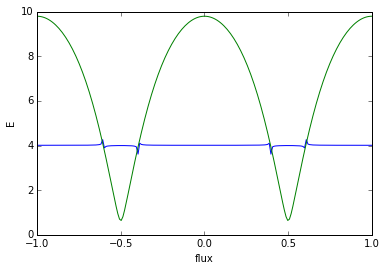

In [16]:
fluxlist = np.linspace(-1, 1, 200)

x =[]
y = []
for change in fluxlist:
    #x.append(Hq_rot(1, 10, 10, 0.5, change, 0.05, 1,3)[3] + permutation(1, 10, 10, 0.5, change, 0.05, 1, 0.08, 3, 3))
    x.append(E_total(3, 1.3, 12.7, 10, 0.5, change, 0.05, 4, 0.3, 3)-E_total(1, 1.3, 12.7, 10, 0.5, change, 0.05, 4, 0.3, 3)) # E_total(i, Ec, Ej, N_cutoff, ng, flux, d, w_lc, g_lc, N_phonon)
    y.append(Hq_z(1.3, 12.7, 10, 0.5, change, 0.05)[1]-Hq_z(1.3, 12.7, 10, 0.5, change, 0.05)[0])


plt.plot(fluxlist , x)
plt.plot(fluxlist , y)

plt.xlabel('flux')# make axis labels
plt.ylabel('E')
plt.xlim(-1, 1)# set axis limits
#plt.ylim(1, 2.5)# set y axis
plt.show()